# Setup

## Colab

In [1]:
# Mount the drive and move to dir
from google.colab import drive
drive.mount("/content/drive", force_remount = False)
%cd /content/drive/MyDrive/Coding/spread-res/runscr/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Coding/spread-res/runscr


## Imports

In [ ]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import os
import sys

import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the model architecture
# from classes.models import BertPos

# Import the utilities and the dataloader
from utils import inferutil, setuputil, trainutil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)
# importlib.reload(BertPos)

# Import the model and funcs required from utils
# from classes.models.BertPos import BertPos
from utils.inferutil import infer_full, infer_one
from utils.setuputil import display_config, setup_config
from utils.trainutil import train_model

## Configuration

Default vars invisible below with their default values:

device = cuda/mps:0 (env-specific), threads = 1 to inf (env-specific), seed = 0 to inf, data_dir = ../data, rows = 100, cols = 100, tokens = 32, save_dir = ../models/

In [ ]:
# Restart
from utils import setuputil

importlib.reload(setuputil)
from utils.setuputil import display_config, setup_config

# Setup the config
# input_config = {
#     # Environment and Model Info
#     "env": "colab",
#     "approach": "bert",
#     "model_name": "BertGridNew",
#     "model_base": "bert-base-cased",
#     "data_ds": "50",
#     # BERT Architecture Parameters
#     "vocab_size": 30522,
#     "hidden_size": 32,
#     "num_hidden_layers": 1,
#     "num_attention_heads": 1,
#     "intermediate_size": 128,
#     "gradient_checkpointing": False,
#     # Training Parameters
#     "batch_size": 50,
#     "lr": 5e-3,
#     "mu": 0.25,
#     "epochs": 20,
#     "patience": 2,
#     "save_int": 0,
# }

input_config = {
    # Environment and Model Info
    "env": "local",
    "approach": "bert",
    "model_name": "BertGridNew",
    "model_base": "bert-base-cased",
    "data_ds": "manual",
    # BERT Architecture Parameters
    "vocab_size": 30522,
    "hidden_size": 32,
    "num_hidden_layers": 1,
    "num_attention_heads": 1,
    "intermediate_size": 128,
    "gradient_checkpointing": False,
    # Training Parameters
    "batch_size": 10,
    "lr": 1e-2,
    "mu": 0.25,
    "epochs": 10,
    "patience": 2,
    "save_int": 0,
}
config = setup_config(input_config)
display_config(config)

# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]

# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch_size"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

Processing files: 100%|██████████| 40/40 [00:04<00:00,  8.02it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 4700.03it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 8745.42it/s]



5(P) = 5(G) + 0(E)

FINAL CONFIG:
{
  "env": "local",
  "approach": "bert",
  "DEVICE": "<device>",
  "THREADS": 8,
  "seed": 0,
  "model_base": "bert-base-cased",
  "model_name": "BertGridNew",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "data_ds": "manual",
  "data_dir": "../data",
  "train_dir": "../data/manual_train",
  "val_dir": "../data/manual_val",
  "test_dir": "../data/manual_test",
  "tokenizer": "<BertTokenizerFast>",
  "vocab_size": 30522,
  "hidden_size": 32,
  "num_hidden_layers": 1,
  "num_attention_heads": 1,
  "intermediate_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "max_position_embeddings": 64,
  "type_vocab_size": 2,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "pad_token_id": 0,
  "gradient_checkpointing": false,
  "train_loader": "<LoaderBert>",
  "val_loader": "<LoaderBert>",
  "test_loader": "<LoaderBert>",
  "batch_size": 20,
  "lr": 0.01,
  "mu": 0.25,
  "epochs": 10,
  "patienc

# NEW TESTER

## Model Creation -> Single Example Check

In [ ]:
# Imports
import math

import torch
import torch.nn as nn
from tqdm import tqdm
from transformers import AutoModel, BertConfig, BertModel
from transformers.models.bert.modeling_bert import BertEncoder


# Define the BertGridNew class
class BertGridNew(nn.Module):
    """A BERT-based model that combines positional and content understanding for grid-structured data.

    This model processes grid-structured input through BERT embeddings enriched with positional
    encodings for both row and column positions. It uses a combination of BERT encoding and
    positional information to create a rich representation of grid cells.

    Args:
    config (dict): Configuration dictionary containing model parameters.
    """

    def __init__(self, config):
        super().__init__()

        # Extract common params
        self.device = config["DEVICE"]
        self.rows = config["rows"]
        self.cols = config["cols"]
        self.seq_len = config["tokens"]
        self.hidden_size = config["hidden_size"]
        self.hidden_dropout_prob = config["hidden_dropout_prob"]

        # Create config to be used for both base model and encoder
        self.bert_config = BertConfig(
            vocab_size=config["vocab_size"],
            hidden_size=self.hidden_size,
            intermediate_size=config["intermediate_size"],
            num_hidden_layers=config["num_hidden_layers"],
            num_attention_heads=config["num_attention_heads"],
            hidden_act=config["hidden_act"],
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=config["attention_probs_dropout_prob"],
            max_position_embeddings=config["max_position_embeddings"],
            type_vocab_size=config["type_vocab_size"],
            layer_norm_eps=config["layer_norm_eps"],
            initializer_range=config["initializer_range"],
            pad_token_id=config["pad_token_id"],
            gradient_checkpointing=config["gradient_checkpointing"],
            seed=config["seed"],
        )

        # Initialize both the BERT model and the enriched encoder using the same config.
        self.bertModel_cell = BertModel(self.bert_config)
        self.bertEncoder_spatial = BertEncoder(self.bert_config)

        # Precompute pos encs for grid cells [max(rows, cols), hidden_size]
        self.pos_encodings = self.get_posEncoding(self.rows, self.cols)

        # Final binary classification layers wrapped sequentially
        self.binary_classifier = nn.Sequential(
            nn.Dropout(self.hidden_dropout_prob),
            nn.GELU(),
            nn.Linear(self.hidden_size, 1),
        )

    # Function to get positional encodings for cells
    def get_posEncoding(self, num_rows, num_cols):
        """Generates optimized positional encodings for grid cells using sinusoidal functions.

        Optimized version that uses broadcasting and combined calculations to reduce
        computational overhead while maintaining the same mathematical properties as
        the original implementation.
        """
        # Calculate all position indices at once to get row/col indices
        positions = torch.arange(num_rows * num_cols, device=self.device)
        i = positions // num_cols
        j = positions % num_cols

        # Create hidden dimension vector for frequency calculations
        frequency_base = 8.0 * (
            torch.arange(self.hidden_size, device=self.device) + (j[:, None] % 2)
        )

        # Combine components to get final encodings
        posEncoding = (torch.sin(i[:, None] / (10 ** (frequency_base / num_rows)))) + (
            torch.sin(j[:, None] / (10 ** (frequency_base / num_cols)))
        )

        return posEncoding

    # Normal optimized forward function
    def forward(self, input_ids, attention_mask):
        """Processes input through the model to generate grid cell representations.

        Takes tokenized input for each cell in the grid, processes it through BERT,
        combines it with positional information, and generates final cell representations
        through an encoder and classification head.

        Args:
            input_ids (torch.Tensor): Tensor of shape [batch_size, rows, cols, seq_len]
            containing token IDs for each cell in the grid.
            attention_mask (torch.Tensor): Tensor of shape [batch_size, rows, cols,     seq_len] containing attention masks for each cell.

        Returns:
            torch.Tensor: A tensor of shape [batch_size, rows, cols] containing the final
        representations for each cell in the grid (S_cube).
        """

        # Retrieve dims and initialize init tensor for posContext embeddings
        batch_size, rows, cols, seq_len = input_ids.shape
        posContext_embeddings = torch.zeros(
            (batch_size, rows * cols, self.hidden_size),
            device=input_ids.device,
        )

        # Build enriched encodings combining content and position understanding
        for cell in range(rows * cols):

            # Define row and column indices for current cell
            row = cell // self.cols
            col = cell % self.cols

            # Calculate the enriched encoding for the cell
            posContext_embeddings[:, cell, :] = (
                self.bertModel_cell(
                    input_ids=input_ids[:, row, col, :],
                    attention_mask=attention_mask[:, row, col, :],
                ).pooler_output
                + self.pos_encodings[cell]
            )

        # Process through encoder and classification head, reshape to grid format
        S_cube = (
            self.binary_classifier(self.bertEncoder_spatial(posContext_embeddings)[0])
            .squeeze(-1)
            .reshape(batch_size, rows, cols)
        )

        # Return the S_cube
        return S_cube

In [ ]:
# # Create check loader from the train_loader Dataset and get first batch
# check_loader = torch.utils.data.DataLoader(train_loader, batch_size=2, shuffle=False)
# check_batch = next(iter(check_loader))

# # Extract all the relevant tensors/info at loc and print info
# ex_file = check_batch["file_paths"]
# ex_xtok = check_batch["x_tok"].to(DEVICE)
# ex_xmasks = check_batch["x_masks"].to(DEVICE)
# ex_ytok = check_batch["y_tok"]
# print(f"Filename: {ex_file}")
# print(f"x_tok shape: {ex_xtok.shape}")
# print(f"x_masks shape: {ex_xmasks.shape}")
# print(f"y_tok shape: {ex_ytok.shape}\n")

# # Define the model and move it to the device
# untrained_model = BertGridNew(config).to(DEVICE)
# print(untrained_model)

# # Output see compare
# out = untrained_model(ex_xtok, ex_xmasks)
# print(f"Output shape: {out.shape}")

In [ ]:
# import matplotlib.pyplot as plt

# # Select dimensions to visualize (let's pick some sine-cosine pairs)
# dimensions = [(0, 1), (10, 11), (30, 31), (50, 51)]  # pairs of sin/cos dimensions
# num_rows = len(dimensions)

# # Create subplot grid
# fig, axes = plt.subplots(num_rows, 2, figsize=(15, 3 * num_rows))

# # For each dimension pair
# for idx, (dim1, dim2) in enumerate(dimensions):
#     # Get values for this dimension across all positions
#     dim1_values = ex_oldenc[:, dim1].cpu().numpy()  # all positions, dimension dim1
#     dim2_values = ex_oldenc[:, dim2].cpu().numpy()  # all positions, dimension dim2

#     # X-axis will be positions
#     positions = range(len(ex_oldenc))

#     # Plot dimension 1 (sine)
#     axes[idx, 0].plot(positions, dim1_values, "b-", linewidth=2)
#     axes[idx, 0].set_title(f"Dimension {dim1} (sine)")
#     axes[idx, 0].grid(True)
#     axes[idx, 0].set_ylim(-1.1, 1.1)
#     axes[idx, 0].set_xlabel("Position")
#     axes[idx, 0].set_ylabel("Encoding Value")

#     # Plot dimension 2 (cosine)
#     axes[idx, 1].plot(positions, dim2_values, "r-", linewidth=2)
#     axes[idx, 1].set_title(f"Dimension {dim2} (cosine)")
#     axes[idx, 1].grid(True)
#     axes[idx, 1].set_ylim(-1.1, 1.1)
#     axes[idx, 1].set_xlabel("Position")
#     axes[idx, 1].set_ylabel("Encoding Value")

# plt.tight_layout()
# plt.show()

In [ ]:
# # Single forward pass
# # Put model in evaluation mode
# untrained_model.eval()

# # Since we're just testing, we don't need gradients
# with torch.no_grad():
#     # Forward pass
#     output = untrained_model(
#         input_ids=ex_xtok,
#         attention_mask=ex_xmasks
#     )

#     # Print output shape and a sample of predictions
#     print(f"\nOutput shape: {output.shape}")
#     print(f"Sample predictions (first few values):\n{output[0, 0, :5]}")  # First row, first 5 values

#     # If you want to see the actual binary predictions, apply sigmoid
#     binary_preds = torch.sigmoid(output)
#     print(f"\nBinary predictions (first few values):\n{binary_preds[0, 0, :5]}")

# Model Training

In [ ]:
# Create and observe the model
untrained_model = BertGridNew(config).to(DEVICE)
print(untrained_model)

BertGridNew(
  (bertModel_cell): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 32, padding_idx=0)
      (position_embeddings): Embedding(64, 32)
      (token_type_embeddings): Embedding(2, 32)
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=32, out_features=32, bias=True)
              (key): Linear(in_features=32, out_features=32, bias=True)
              (value): Linear(in_features=32, out_features=32, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=32, out_features=32, bias=True)
              (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)


## Training Metrics

1. GPU Model: 517 mb
2. GPU Training: 36.7 gb

3. Per Epoch Train Time: 38s
4. Per Epoch Val Time: 15s
5. Last Epoch: 16


In [ ]:
# Train with adjusted batch size
trained_model = train_model(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config,
    isPerp=True,
)

Epoch 0


Batch Processing:   0%|          | 0/2 [00:39<?, ?it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 35.38 GB, other allocations: 2.83 MB, max allowed: 36.27 GB). Tried to allocate 1.86 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

# Evaluation

In [ ]:
# Params
loc = 0
thresh = 0.89
infer_batch_size = 50

# # Load the pretrained weights and assign to trained model
# untrained_model.load_state_dict(
#     torch.load(
#         "../models/ber0c_bbcBertPos_manual10010032_ba40lr1e-2ep20pa2_v30kh32l1i128a1_20250210_210415.pth",
#         map_location=DEVICE,
#         weights_only=True,
#     )
# )
# trained_model = untrained_model.eval()

## Single Example


Filename: ../data/50_train/5%20ORD-013745%20CTD%20Chemical-gene%20interactions.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(2,1): 0.890038 | (2,3): 0.890461 | (2,2): 0.890608 | (2,4): 0.892297 | (2,5): 0.892956 | (2,0): 0.893046 | (2,6): 0.893372 | (0,0): 0.894876

NB to B ratio: Predicted = 9990:10 | Actual = 9992:8
Accuracy: 99.98% | Precision: 80.00% | Recall: 100.00% | F1-Score: 0.89



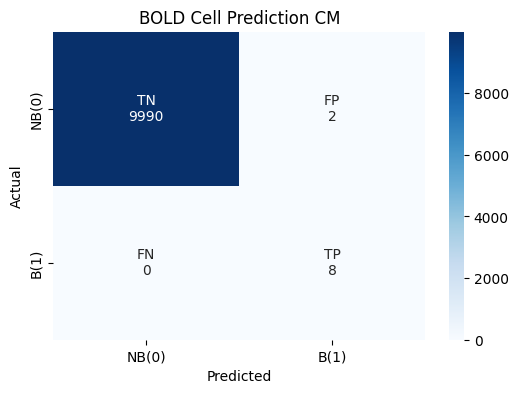


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
2,1,1,1,1,1,1,1
8,0,1,0,0,0,0,0
11,0,0,0,1,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
2,1,1,1,1,1,1,1


In [ ]:
# Inference on single position of train_loader
infer_one(
    trained_model=trained_model,
    infer_loader=train_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)


Filename: ../data/50_val/LMDI_Combined.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
No bold cells in the actual data.

NB to B ratio: Predicted = 9997:3 | Actual = 10000:0
Accuracy: 99.97% | Precision: 0.00% | Recall: 0.00% | F1-Score: 0.00



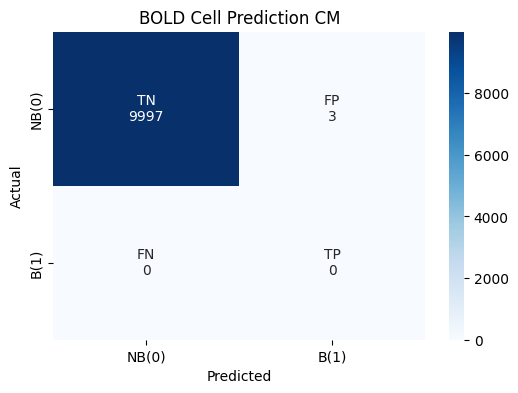


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,3
0,0,1
6,1,0
9,0,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---
No bold cells in actual data.


In [ ]:
# Inference on single position of val_loader
infer_one(
    trained_model=trained_model,
    infer_loader=val_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)


Filename: ../data/50_test/retrospective-review-plan-report-20150317.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(0,0): 0.058434 | (0,9): 0.087397 | (0,11): 0.098364 | (0,10): 0.186540 | (0,7): 0.192257 | (0,6): 0.796434 | (0,8): 0.891921 | (0,3): 0.892734 | (0,2): 0.892932 | (0,5): 0.893503 | (0,1): 0.894059 | (0,4): 0.894467

NB to B ratio: Predicted = 9957:43 | Actual = 9988:12
Accuracy: 99.57% | Precision: 13.95% | Recall: 50.00% | F1-Score: 0.22



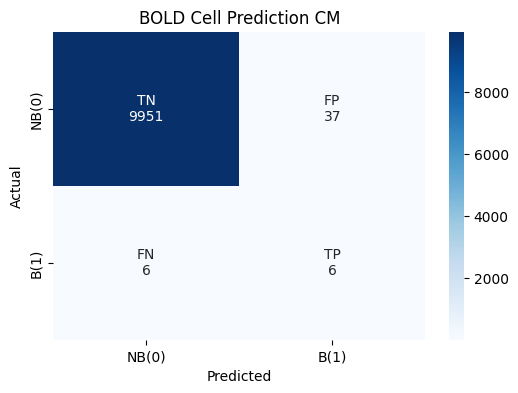


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,7,8,11
0,0,1,1,1,1,1,0,1,0
1,1,1,1,1,0,0,1,0,0
2,1,1,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,0,1
4,1,1,0,0,0,0,1,0,1
5,1,0,1,1,0,0,1,0,1
6,1,0,1,1,0,0,0,0,1
7,1,1,0,0,0,0,0,0,0
8,1,0,1,1,0,0,0,0,0
9,1,1,1,0,1,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11
0,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
# Inference on single position of test_loader
infer_one(
    trained_model=trained_model,
    infer_loader=test_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)

## All Examples

Batch Inference: 100%|██████████| 1/1 [00:15<00:00, 15.13s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 399429:571 | Actual = 399199:801
Accuracy: 99.81% | Precision: 55.34% | Recall: 39.45% | F1-Score: 0.46



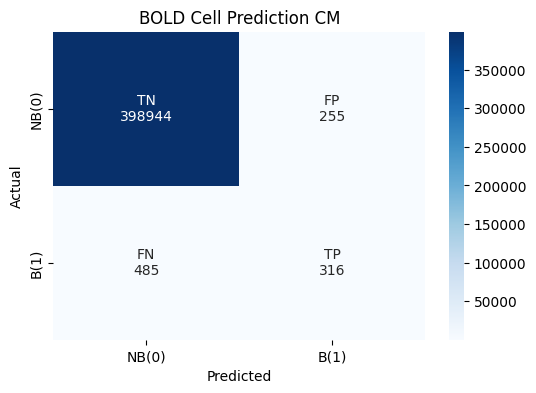

In [ ]:
# Infer across all examples of train_loader
infer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 1/1 [00:14<00:00, 14.59s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49902:98 | Actual = 49846:154
Accuracy: 99.76% | Precision: 66.33% | Recall: 42.21% | F1-Score: 0.52



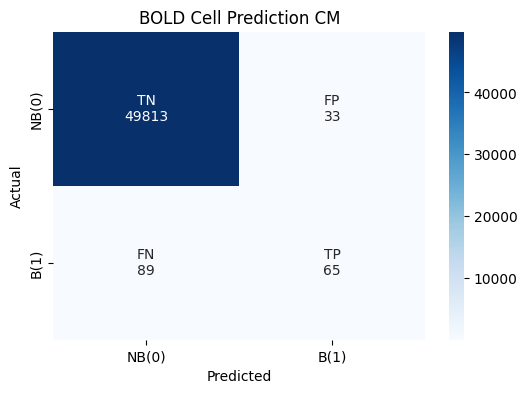

In [ ]:
# Infer across all examples of val_loader
infer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 1/1 [00:14<00:00, 14.60s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49806:194 | Actual = 49801:199
Accuracy: 99.55% | Precision: 43.30% | Recall: 42.21% | F1-Score: 0.43



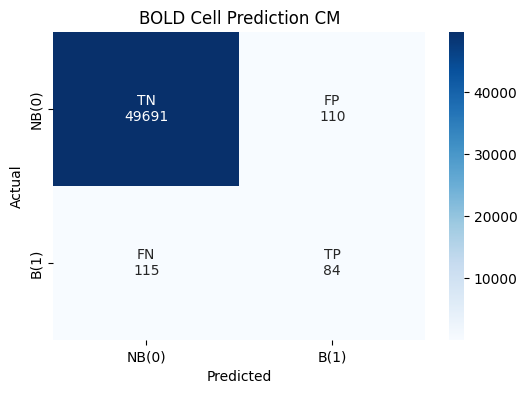

In [ ]:
# Infer across all examples of test_loader
infer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)